In [1]:
# !pip uninstall torch torchaudio torchvision -y

In [2]:
# !pip install torch==2.2.2 torchaudio==2.2.2

In [3]:
!pip install torch torchaudio torchvision datasets -q

In [96]:
import random
import IPython
import warnings
warnings.filterwarnings("ignore")

import datasets

from datasets.utils import DownloadManager

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, roc_curve, auc

from scipy.optimize import brentq
from scipy.interpolate import interp1d

import torch
import torchaudio
import torchaudio.transforms as T

from torch.utils.data import DataLoader, Dataset

import os
import sys

from tqdm import tqdm
import torchvision
import soundfile as sf
import torch.nn as nn
import torchvision.models as models
from librosa import util
import librosa.feature

import matplotlib.pyplot as plt
import math

In [2]:
sys.path.append('src')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Dataset .zip from link

Logical access (LA):

- ```speaker_id:``` LA_****, a 4-digit speaker ID
- ```audio_file_name:``` name of the audio file
- ```audio:``` '****.flac'  the path to the downloaded audio file in FLAC format (https://xiph.org/flac/).
- ```system_id:``` ID of the speech spoofing system (A01 - A19), or, for bonafide speech SYSTEM-ID is left blank ('-')
- ```key:``` 'bonafide' for genuine speech, or, 'spoof' for spoofing speech

## ASVspoof2019

In [7]:
# # For kaggle
# import sys
# sys.path.append('/kaggle/input/modulesspeechdetection')


In [4]:
%%time
from load_avsspoof19 import ASVspoof2019

dl_manager = DownloadManager()

speech_dataset = ASVspoof2019()
asv_datasets = speech_dataset._split_generators(dl_manager)

Computing checksums: 100%|##########| 1/1 [00:23<00:00, 23.55s/it]

CPU times: user 22.4 s, sys: 1.35 s, total: 23.7 s
Wall time: 59.5 s


In [5]:
# 0 - train, 1 - eval, 2 - test in asv_datasets
train_metadata_filepath = asv_datasets[0].gen_kwargs["metadata_filepath"]
train_audios_dir = asv_datasets[0].gen_kwargs["audios_dir"]

val_metadata_filepath = asv_datasets[1].gen_kwargs["metadata_filepath"]
val_audios_dir = asv_datasets[1].gen_kwargs["audios_dir"]

test_metadata_filepath = asv_datasets[2].gen_kwargs["metadata_filepath"]
test_audios_dir = asv_datasets[2].gen_kwargs["audios_dir"]

In [6]:
train_samples = speech_dataset._generate_examples(train_metadata_filepath, train_audios_dir)
val_samples = speech_dataset._generate_examples(val_metadata_filepath, val_audios_dir)
test_samples = speech_dataset._generate_examples(test_metadata_filepath, test_audios_dir)

## ASVspoof2021

In [7]:
%%time
from load_avsspoof21 import ASVspoof2021

dl_manager = DownloadManager(data_dir="data")

speech_dataset = ASVspoof2021()
asv_datasets = speech_dataset._split_generators(dl_manager)

Computing checksums:  20%|##        | 1/5 [00:26<01:46, 26.67s/it]

CPU times: user 1min 45s, sys: 9.61 s, total: 1min 55s
Wall time: 1min 57s


In [8]:
test_samples_21 = speech_dataset._generate_examples(
    asv_datasets[0].gen_kwargs["metadata_filepath"],
    asv_datasets[0].gen_kwargs["audios_dir"]
)

## Listen to random sample

Display some audio from train/validation set.

In [207]:
def get_sample(samples):
    return random.sample(samples, k=1)[0]

sample = get_sample(train_samples)
sample

{'speaker_id': 'LA_0097',
 'audio_file_name': 'LA_T_9114515',
 'system_id': 'A03',
 'key': 'spoof',
 'audio': '/root/.cache/huggingface/datasets/downloads/extracted/911103f86670b6f7e96211444d0f39fc5ffab511156a395f67b098c2f45dce18/LA/ASVspoof2019_LA_train/flac/LA_T_9114515.flac'}

In [208]:
print(sample['key'])
IPython.display.Audio(sample['audio'])

spoof


In [211]:
sample = get_sample(test_samples_21)
sample

{'speaker_id': 'TGF1',
 'audio_file_name': 'DF_E_2595839',
 'system_id': 'Task2-team25',
 'src': 'vcc2020',
 'key': 'spoof',
 'audio': 'data/ASVspoof2021-DF-full/flac/DF_E_2595839.flac'}

In [212]:
print(sample['key'])
IPython.display.Audio(sample['audio'])

spoof


## Audio preprocessing


In [9]:
def audio_preprocess(waveform, sample_rate, resample_rate, desired_duration):
    """
        Resample audio to target frequency (16 kHz or 22.05 kHz) \
        Set equal duration for all audios
    """
    resampler = T.Resample(sample_rate, resample_rate)
    resampled_waveform = resampler(waveform)

    desired_length = int(desired_duration * resample_rate)
    if len(resampled_waveform) < desired_length:
        resampled_waveform = resampled_waveform.tile(((desired_length // resampled_waveform.shape[1]) + 1,))
    resampled_waveform = resampled_waveform[:,0: desired_length]

    return resampled_waveform


def peak_normalize(waveform):
    """
        Normalize audio
    """
    waveform /= torch.max(torch.abs(waveform))
    return waveform

In [10]:
class AudioDataset(Dataset):
    def __init__(self, raw_dataset, desired_duration, resample_rate, transform=None):
        self.raw_data = raw_dataset
        self.transform = transform
        self.sample_rate = resample_rate
        self.duration = desired_duration

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.raw_data[idx]['audio'])
        if self.transform:
            waveform = self.transform[0](waveform, sample_rate, self.sample_rate, self.duration)
            waveform = self.transform[1](waveform)

        label = 1 if self.raw_data[idx]['key'] == 'spoof' else 0
        return waveform, label

## ASVspoof19

In [11]:
_DURATION = 6
_SAMPLE_RATE = 16_000
_BATCH_SIZE = 36
_TEST_SIZE = math.floor(len(test_samples) / _BATCH_SIZE) * _BATCH_SIZE

train_dataset = AudioDataset(train_samples, _DURATION, _SAMPLE_RATE, transform=[audio_preprocess, peak_normalize])
train_loader= DataLoader(train_dataset, batch_size=_BATCH_SIZE, shuffle=True)

test_dataset = AudioDataset(
    test_samples[:_TEST_SIZE],
    _DURATION, _SAMPLE_RATE,
    transform=[audio_preprocess, peak_normalize]
)
test_loader= DataLoader(test_dataset, batch_size=_BATCH_SIZE, shuffle=False)

In [12]:
len(train_samples), len(train_loader)

(25380, 705)

## ASVspoof21

In [13]:
_DURATION = 6
_SAMPLE_RATE = 16_000
_BATCH_SIZE = 36

test_dataset_21 = AudioDataset(
    test_samples_21[:_TEST_SIZE],
    _DURATION, _SAMPLE_RATE,
    transform=[audio_preprocess, peak_normalize]
)
test_loader_21 = DataLoader(test_dataset_21, batch_size=_BATCH_SIZE, shuffle=False)

In [14]:
len(test_samples_21), len(test_loader_21)

(611829, 1978)

# Feature Extraction Definition
Log power spectrum (LPS), Mel-frequency cepstrum coefficient (MFCC), constant Q cepstral coefficient (CQCC).

In [15]:
from feature_ext import get_MFCC, get_CQCC, get_LPS

feature_extractor = 'MFCC' # 'CQCC' 'LPS'
feature_extr = {
        'MFCC': get_MFCC,
        'CQCC': get_CQCC,
        'LPS': get_LPS
}

# Model definition

In [16]:
from models import TE_ResNet

# Metrics Definition

In [17]:
from metrics import compute_det_curve, compute_eer, plot_roc

# Training

In [101]:
def truncate_sequence(features, max_length):
    batch_size, seq_length, feature_dim = features.size()
    if seq_length > max_length:
        features = features[:, :max_length, :]
    else:
        padding = torch.zeros(batch_size, max_length - seq_length, feature_dim, device=features.device)
        features = torch.cat((features, padding), dim=1)
    return features

def train_loop(model, loader, feature_extractor, criterion, optimizer, n_epochs, device, max_length):
    feature_extr = {
        'MFCC': get_MFCC,
        'CQCC': get_CQCC,
        'LPS': get_LPS
    }

    for epoch in range(n_epochs):
        model.train(True)
        sum_loss = 0.0
        num_correct = 0
        total_samples = 0
        acc, precision, recall = 0.0, 0.0, 0.0

        for data, labels in tqdm(loader):
            data = data.to(device)
            labels = labels.to(device)

            # Extract features
            if feature_extractor in feature_extr:
                features = feature_extr[feature_extractor](data, loader.dataset.sample_rate)
            else:
                raise ValueError(f"Invalid feature extractor: {feature_extractor}")

            features = features.to(device)

            # Forward pass through the model
            features = features.unsqueeze(1)
            output = model(features)

            # Check for shape mismatch
            if output.shape[0] != labels.shape[0]:
                raise ValueError(f"Mismatch in batch sizes: output batch size {output.shape[0]}, labels batch size {labels.shape[0]}")

            # Compute loss
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            sum_loss += loss.item()
            max_val, predicted = output.max(1)
            acc += balanced_accuracy_score(labels.cpu(), predicted.cpu())
            precision += precision_score(labels.cpu(), predicted.cpu(),  average='binary')
            recall += recall_score(labels.cpu(), predicted.cpu(),  average='binary')

        train_avg_acc = acc / len(loader)
        train_avg_loss = sum_loss / len(loader)
        train_avg_prec = precision / len(loader)
        train_avg_recall = recall / len(loader)
        print(f'Epoch [{epoch+1}/{n_epochs}], Training Accuracy: {train_avg_acc:.4f}, Training Loss: {train_avg_loss:.4f}, \
Training Precision: {train_avg_prec:.4f}, Training Recall: {train_avg_recall:.4f}')
        
    return train_avg_loss, train_avg_acc, train_avg_prec, train_avg_recall



# Evaluation

In [99]:
eval_asvspoof_resnet18 = {}
eval_asvspoof_teresnet = {}

In [102]:
def evaluate_model(model, test_loader, feature_extractor, criterion, device, max_length):
    feature_extr = {
        'MFCC': get_MFCC,
        'CQCC': get_CQCC,
        'LPS': get_LPS
    }

    model.eval()
    test_loss = 0.0
    test_correct = 0
    total_test_samples = 0
    target_scores, non_target_scores = [], []
    acc, precision, recall = 0.0, 0.0, 0.0
    true_labels = []
    

    with torch.no_grad():
        for waveform, label in tqdm(test_loader):
            waveform, label = waveform.to(device), label.to(device)

            # Extract features
            if feature_extractor in feature_extr:
                features = feature_extr[feature_extractor](waveform, test_loader.dataset.sample_rate)
            else:
                raise ValueError(f"Invalid feature extractor: {feature_extractor}")


            features = features.to(device)

            # Forward pass through the model
            features = features.unsqueeze(1)
            output = model(features)

            # Check for shape mismatch
            if output.shape[0] != label.shape[0]:
                raise ValueError(f"Mismatch in batch sizes: output batch size {output.shape[0]}, label batch size {label.shape[0]}")

            # Compute loss
            loss = criterion(output, label)
            test_loss += loss.item()
    
            _, predicted = output.max(1)
            acc += balanced_accuracy_score(label.cpu(), predicted.cpu())
            target_scores.append(output[:,1].cpu())
            non_target_scores.append(output[:,0].cpu())
            precision += precision_score(label.cpu(), predicted.cpu(),  average='binary')
            recall += recall_score(label.cpu(), predicted.cpu(),  average='binary')
            true_labels.append(label.cpu())
            
    true_labels = torch.cat(true_labels, dim = 0)
    target_scores = torch.cat(target_scores, dim = 0)
    
    test_avg_acc = acc / len(test_loader)
    test_loss /= len(test_loader)
    test_avg_prec = precision / len(test_loader)
    test_avg_recall = recall / len(test_loader)

    print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_avg_acc:.4f}, \
Val Precision: {test_avg_prec:.4f}, Val Recall: {test_avg_recall:.4f}')

    return test_loss, test_avg_acc, test_avg_prec, test_avg_recall, target_scores, true_labels


# Report Results

In [97]:
def plot_roc(true_labels, target_scores):
    """ 
        Function plots ROC curve and calculates AUC 
        for given true_labels and target_scores. 
    """
    fpr, tpr, threshold = roc_curve(true_labels, target_scores)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, threshold, roc_auc

def compute_eer(fpr, tpr, threshold):
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, threshold)(eer)
    return eer

In [98]:
def report(eval_asvspoof):
    """
        Report results for model
    """
    # divide data
    train_data = [eval_asvspoof["MFCC"][0], eval_asvspoof["CQCC"][0], eval_asvspoof["LPS"][0]]
    test_data = [eval_asvspoof["MFCC"][1][:-2], eval_asvspoof["CQCC"][1][:-2], eval_asvspoof["LPS"][1][:-2]]
    test_data_21 = [eval_asvspoof["MFCC"][2][:-2], eval_asvspoof["CQCC"][2][:-2], eval_asvspoof["LPS"][2][:-2]]
    
    # Column and index names
    columns = ['Loss', 'Balanced Accuracy', 'Precision', 'Recall']
    index = ['MFCC', 'CQCC', 'LPS']
    
    # Create DataFrame
    results_train = pd.DataFrame(train_data, columns=columns, index=index)
    results_test = pd.DataFrame(test_data, columns=columns, index=index)
    results_test_21 = pd.DataFrame(test_data_21, columns=columns, index=index)

    print(results_train)
    print(results_test)
    print(results_test_21)

    # colors
    colors = ['darkorange', 'green', 'blue']
    labels = ['ASVspoof19', 'ASVspoof21']
    
    # plot ROC and calculate AUC
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    lw = 2
    colors = ['darkorange', 'green', 'blue']
    
    for i in range(1, 3):
        for j, (key, vals) in enumerate(eval_asvspoof.items()):
            fpr, tpr, threshold, roc_auc = plot_roc(eval_asvspoof[key][i][5], eval_asvspoof[key][i][4])
            eer = compute_eer(fpr, tpr, threshold) * 100
            ax[i - 1].plot(fpr, tpr, color=colors[j], lw=lw, label=f'{key}_ROC curve (area = {roc_auc:.3f}, EER = {int(eer)} %)')
        ax[i - 1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        ax[i - 1].set_xlim([0.0, 1.0])
        ax[i - 1].set_ylim([0.0, 1.05])
        ax[i - 1].set_xlabel('False Positive Rate')
        ax[i - 1].set_ylabel('True Positive Rate')
        ax[i - 1].set_title(f'ROC Curve for Class 1, {labels[i - 1]}')
        ax[i - 1].legend(loc="lower right")

# Evaluation on ASVspoof19 and ASVspoof21 for ResNet18

In [36]:
for feature_extractor in ["MFCC", "CQCC", "LPS"]:
    torch.cuda.empty_cache()
    
    # initialize model
    model = torchvision.models.resnet18(pretrained=True)
    n_ftrs = model.fc.in_features
    model.fc=nn.Linear(n_ftrs,2)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(9, 3), stride=(3, 1), padding=(1, 1), bias=False)
    model.softmax = nn.Softmax(dim=1)
    model.to(device)
    
    # define training parameters
    num_epochs = 3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # train_loss, train_acc, train_precision, train_recall
    train_output = train_loop(
        model,
        train_loader,
        feature_extractor=feature_extractor,
        criterion=criterion,
        optimizer=optimizer,
        n_epochs=num_epochs,
        device=device,
        max_length=188
    )

    torch.save(model.state_dict(), f"weights_resnet18_{feature_extractor}.pt")
    # model.load_state_dict(torch.load(f"weights.pt"))
    
    # test_loss, test_acc, test_precision, test_recall, target_scores, true_labels
    test_output = evaluate_model(
        model,
        test_loader,
        feature_extractor=feature_extractor,
        criterion=criterion,
        device=device,
        max_length=188
    )

    # test_loss, test_acc, test_precision, test_recall, target_scores, true_labels
    test_output_21 = evaluate_model(
        model,
        test_loader_21,
        feature_extractor=feature_extractor,
        criterion=criterion,
        device=device,
        max_length=188
    )
    
    eval_asvspoof_resnet18[feature_extractor] = [train_output, test_output, test_output_21]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [06:34<00:00,  1.79it/s]


Epoch [1/3], Training Accuracy: 0.9294, Training Loss: 0.0780, Training Precision: 0.9826, Training Recall: 0.9871


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [06:33<00:00,  1.79it/s]


Epoch [2/3], Training Accuracy: 0.9799, Training Loss: 0.0316, Training Precision: 0.9949, Training Recall: 0.9953


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [06:36<00:00,  1.78it/s]


Epoch [3/3], Training Accuracy: 0.9816, Training Loss: 0.0254, Training Precision: 0.9952, Training Recall: 0.9962


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1978/1978 [18:00<00:00,  1.83it/s]


Val Loss: 0.4113, Val Accuracy: 0.8930, Val Precision: 0.9865, Val Recall: 0.8929


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1978/1978 [18:05<00:00,  1.82it/s]


Val Loss: 0.2283, Val Accuracy: 0.8013, Val Precision: 0.9813, Val Recall: 0.9661


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [1:21:56<00:00,  6.97s/it]


Epoch [1/3], Training Accuracy: 0.8108, Training Loss: 0.1521, Training Precision: 0.9583, Training Recall: 0.9711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [1:23:17<00:00,  7.09s/it]


Epoch [2/3], Training Accuracy: 0.8888, Training Loss: 0.1005, Training Precision: 0.9742, Training Recall: 0.9794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [1:22:29<00:00,  7.02s/it]


Epoch [3/3], Training Accuracy: 0.9225, Training Loss: 0.0787, Training Precision: 0.9809, Training Recall: 0.9857


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1978/1978 [3:53:49<00:00,  7.09s/it]


Val Loss: 0.3601, Val Accuracy: 0.6612, Val Precision: 0.9280, Val Recall: 0.9609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1978/1978 [3:54:15<00:00,  7.11s/it]


Val Loss: 0.2154, Val Accuracy: 0.6940, Val Precision: 0.9699, Val Recall: 0.9897


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [08:12<00:00,  1.43it/s]


Epoch [1/3], Training Accuracy: 0.9855, Training Loss: 0.0201, Training Precision: 0.9955, Training Recall: 0.9950


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [08:11<00:00,  1.44it/s]


Epoch [2/3], Training Accuracy: 0.9973, Training Loss: 0.0057, Training Precision: 0.9993, Training Recall: 0.9990


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [08:10<00:00,  1.44it/s]


Epoch [3/3], Training Accuracy: 0.9993, Training Loss: 0.0022, Training Precision: 0.9998, Training Recall: 0.9997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1978/1978 [15:54<00:00,  2.07it/s]


Val Loss: 0.5796, Val Accuracy: 0.8389, Val Precision: 0.9882, Val Recall: 0.7584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1978/1978 [16:16<00:00,  2.03it/s]


Val Loss: 0.5335, Val Accuracy: 0.7389, Val Precision: 0.9818, Val Recall: 0.8132


          Loss  Balanced Accuracy  Precision    Recall
MFCC  0.025423           0.981623   0.995165  0.996232
CQCC  0.078704           0.922469   0.980860  0.985715
LPS   0.002216           0.999309   0.999818  0.999741
          Loss  Balanced Accuracy  Precision    Recall
MFCC  0.411315           0.892961   0.986508  0.892908
CQCC  0.360071           0.661162   0.928028  0.960854
LPS   0.579635           0.838900   0.988222  0.758404
          Loss  Balanced Accuracy  Precision    Recall
MFCC  0.228327           0.801297   0.981340  0.966076
CQCC  0.215411           0.694027   0.969880  0.989660
LPS   0.533523           0.738890   0.981785  0.813188


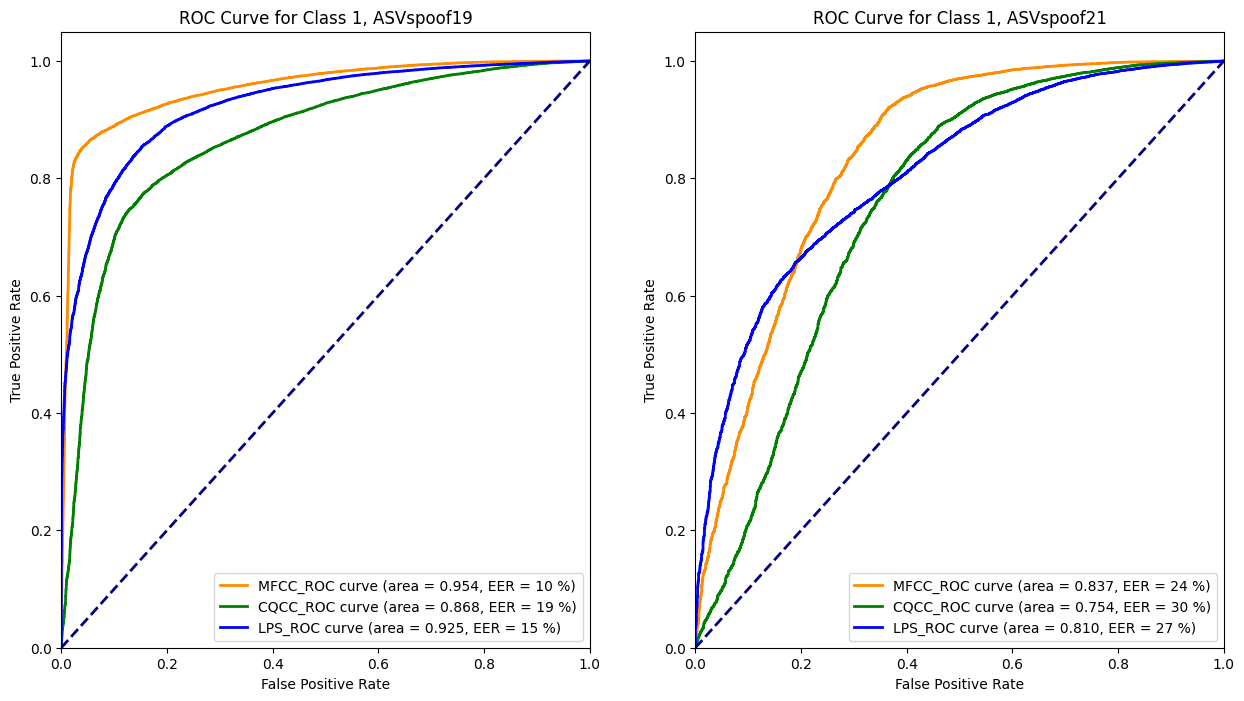

In [95]:
report(eval_asvspoof_resnet18)

# Evaluation on ASVspoof19 and ASVspoof21 for TE-ResNet

In [ ]:
for feature_extractor in ["MFCC"]:#, "CQCC", "LPS"]:
    torch.cuda.empty_cache()

    sample = next(iter(test_loader))[0]
    n_features=feature_extr[feature_extractor](sample, train_loader.dataset.sample_rate).shape[1]
    
    # initialize model
    # in case of te-resnet comment the row 'features=features.unsqueeze(1)' in training and evaluation
    model = TE_ResNet(
        n_features=n_features,
        n_frames=188,
        num_layers=6,
        heads=8,
        hidden_size=256,
        output_channels=128,
        batch_size=_BATCH_SIZE,
        device=device,
    ).to(device)
    
    # define training parameters
    num_epochs = 3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # train_loss, train_acc, train_precision, train_recall
    train_output = train_loop(
        model,
        train_loader,
        feature_extractor=feature_extractor,
        criterion=criterion,
        optimizer=optimizer,
        n_epochs=num_epochs,
        device=device,
        max_length=188
    )

    torch.save(model.state_dict(), f"weights_teresnet_{feature_extractor}.pt")
    # model.load_state_dict(torch.load(f"weights.pt"))
    
    # test_loss, test_acc, test_precision, test_recall, target_scores, true_labels
    test_output = evaluate_model(
        model,
        test_loader,
        feature_extractor=feature_extractor,
        criterion=criterion,
        device=device,
        max_length=188
    )

    # test_loss, test_acc, test_precision, test_recall, target_scores, true_labels
    test_output_21 = evaluate_model(
        model,
        test_loader_21,
        feature_extractor=feature_extractor,
        criterion=criterion,
        device=device,
        max_length=188
    )
    
    eval_asvspoof_teresnet[feature_extractor] = [train_output, test_output, test_output_21]
    
    